# Identifying Face Mask Compliance
Project mentor: Darius Irani

Adyant Balaji <abalaji2@jh.edu>, Christine Ji <cji11@jh.edu>, Rebecca Yu <ryu16@jh.edu>

Link to Git repository:
https://github.com/hittheant/475Project.git

# Outline and Deliverables


### Uncompleted Deliverables
1. "Would like to complete #3": We wanted to have equally high accuracy for images with poor quality (lowlit, small image, grainy), but did not end up doing any data augmentation to do this. 
2. "Would like to complete #2": We wanted to determine whether social distancing was followed in certain images based on distance between identified faces. This would, in fact, not be significantly difficult given the current status of our project, as we would simply have to define a function determining "social distancing adherence" given the mask wearers in the image.
3. "Would like to complete #1": We were unable to add determination of a "safe" situation, but similar to #2, this would not be too difficult given the current status of our project. 
4. "Expect to accomplish #2": We planned on being able to identify with >90% accuracy all individuals in the given photo. 


### Completed Deliverables
1. "Must complete #1": We discuss classifying between masked and unmasked faces [in "Methods" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must complete #2": We discuss placing a bounding box around faces in [in "Baselines" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
3. "Must complete #3": We discuss classifying improper mask wearing [in "Results" below](#scrollTo=_Zdp4_H-kx8H)
4. "Expect to complete #1": We discuss identifying proper, no mask, or improper mask with >90% accuracy in [in "Results" below](#scrollTo=_Zdp4_H-kx8H)
5. "Expect to complete #2": We discuss identifying if at least one person in the image is not wearing a mask [in "Results" below](#scrollTo=_Zdp4_H-kx8H)

# Preliminaries

## What problem were you trying to solve or understand?

Proper mask wearing has been vital to limiting the spread of COVID-19 during this pandemic. However, it is difficult to enforce mask wearing compliance on a wide scale. As compliance is hard to enforce and validate on an individual level, there exists the need for a ML solution to detect mask wearing compliance. The input to our algorithm is an image. We then use a neural network to predict mask compliance in the image. 

At its core this is a multi-class classification problem wherein faces are identified as "proper mask," "improper mask," or "no mask." This is somewhat similar to previous HWs where we have classified numbers or Google QuickDraw images. Another portion of the task involves creating bounding boxes for the detection of faces--this is done using feature extraction via CNNs.

A few ethical concerns of our technologies revolve around the sensitivity of facial data. Facial data itself is private, personal information and for the images that are likely to be used in our case (security cameras, public space images), this could be classified as data without consent. There is the further problem of what is done with this information--whether it could be used for public shaming and discrimination.


## Dataset(s)
We used the face mask detection dataset found [here](https://www.kaggle.com/andrewmvd/face-mask-detection/notebooks). The dataset contains 854 images, which contain individuals who can be labelled as "no mask", "improper mask", or "proper mask." It is important here to note that these classes are not balanced in the dataset. 

In [1]:
import os
import cv2
import sys
import random
import torchvision
from bs4 import BeautifulSoup
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.dirname(os.path.abspath("mrcnn_integration"))

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

class FacesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    NAME = "faces"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    NUM_CLASSES = 1 + 3  # background + 3 labels
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = FacesConfig()

In [2]:
np.random.seed(0)
NUM_IMGS = 853  # images 0 through 852
IDS = np.arange(NUM_IMGS) + 1
np.random.shuffle(IDS)
TRAIN_IDS = IDS[:int(NUM_IMGS * .7)]  # [f'maksssksksss{x}' for x in IDS[:int(NUM_IMGS * .7)]]
VALID_IDS = IDS[int(NUM_IMGS * .7):int(NUM_IMGS * .9)]  #[f'maksssksksss{x}' for x in IDS[int(NUM_IMGS * .7):int(NUM_IMGS * .9)]]
TEST_IDS = IDS[int(NUM_IMGS * .9):]  #[f'maksssksksss{x}' for x in IDS[int(NUM_IMGS * .9):]]

TARGET_SHAPE = (128,128)
FILEPATH = './archive'

## Pre-processing

We did not opt to not use any features because we felt that we could not immediately pinpoint features that would be useful.

Originally, our dataset was not class-balanced. In particular we had comparatively fewer images of "improper mask" and much more of "no mask." We found this to be a problem, as the first run of our network made no "improper mask" predictions. We resolved this by training the network on a balanced dataset.

In preprocessing steps, we rescaled our images so that images were 128 x 128 and faces were 30 x 30. We also normalized to improve learning. 

Overall code for preprocessing our data is in our `load_data.py` function. It includes functions to load image data, crop faces according to their ground truth bounding boxes, and balancing data. Below, we'll be including some code to display our data and information about our data.

### Distribution of Labels

In [3]:
def plot_bar_graphs(emotion_keys, true_counts, pred_counts, gt_only):
    index = np.arange(len(emotion_keys))
    plt.bar(index, true_counts)
    plt.xticks(index, emotion_keys)
    plt.ylabel('Count')
    plt.ylim(0, true_counts.max() * 1.2)
    plt.title('True Labels by Mask Adherence')
    plt.show()
    
def create_dist_plots(labels, predictions, emotion_keys, gt_only=False):
    true_counts = np.zeros((len(emotion_keys)))
    pred_counts = np.zeros((len(emotion_keys)))
    for val in range(len(emotion_keys)):
        true_counts[val] = np.count_nonzero(labels == val)
        pred_counts[val] = np.count_nonzero(predictions == val)    
    plot_bar_graphs(emotion_keys, true_counts, pred_counts, gt_only=gt_only)

In [4]:
keys = ['no mask', 'mask', 'incorrect mask']
labels = np.load('./archive/raw_splits/y_train.npy')
balanced_labels = np.load('./archive/balanced_splits/y_train.npy')

##### Native distribution of labels before balancing

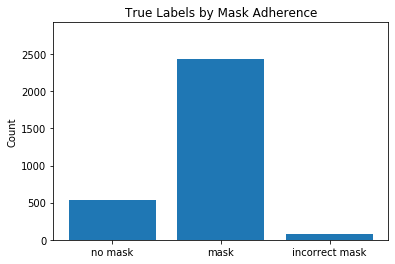

In [5]:
create_dist_plots(labels, None, keys, gt_only=True)

##### Distribution of labels after balancing

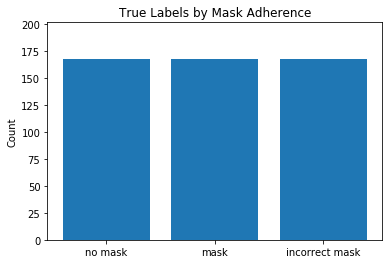

In [6]:
create_dist_plots(balanced_labels, None, keys, gt_only=True)

### Images

##### Input images

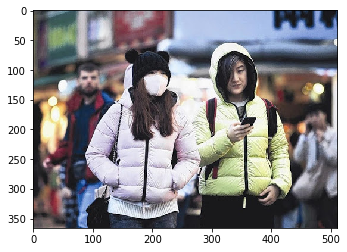

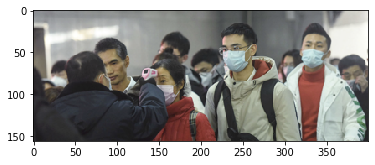

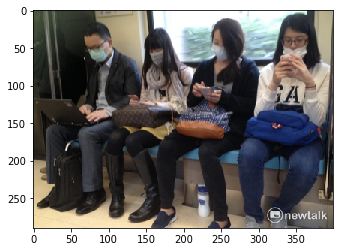

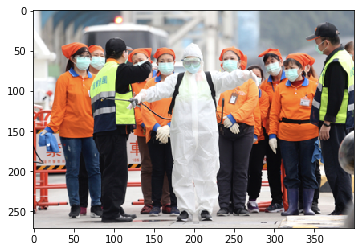

In [7]:
for i in range(4):
    filename = f'{FILEPATH}/images/maksssksksss{i}.png'
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img)

In [11]:
class FacesDataset(utils.Dataset):
    """Loads and processes the faces dataset.
    """
    def load_data(self, subset, filepath=FILEPATH):
        assert subset in ['train', 'val', 'test']
        self.add_class('masks', 0, 'no mask')
        self.add_class('masks', 1, 'mask')
        self.add_class('masks', 2, 'improper mask')
        
        # load ids of subsets
        if subset == 'train':
            image_ids = TRAIN_IDS
        elif subset == 'val':
            image_ids = VALID_IDS
        else:
            image_ids = TEST_IDS
            
        # add images
        for image_id in image_ids:
            self.add_image(source='masks', image_id=image_id, path=f'{FILEPATH}/images/{image_id - 1}.png')

    def image_reference(self, image_id):
            info = self.image_info[image_id]
            if info['source'] == 'masks':
                return info['masks']
            else:
                super(self.__class__).image_reference(self, image_id)
            return info

    def load_mask(self, image_id):
        def get_image_info(soup):
            info = self.image_info[image_id]
            info['height'] = int(soup.find('height').text)
            info['width'] = int(soup.find('width').text)
            info['boxes'] = soup.find_all('object')
            info['count'] = len(info['boxes'])
            return info
        f = open(f'{FILEPATH}/annotations/maksssksksss{image_id - 1}.xml')
        data = f.read()
        soup = BeautifulSoup(data, 'html.parser')
        info = get_image_info(soup)
        self.image_info[image_id]
        shapes = info['boxes']
        mask = np.zeros([info['height'], info['width'], info['count']], dtype=np.uint8)
        class_ids = []
        for i, (obj) in enumerate(info['boxes']):
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            mask[ymin:ymax, xmin:xmax, i] = 1
            
            if obj.find('name').text == 'with_mask':
                class_ids.append(2)
            elif obj.find('name').text == 'without_mask':
                class_ids.append(1)
            else:
                class_ids.append(3)

        mask = np.array(mask)
        class_ids = np.array(class_ids)
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def load_image(self, image_id):
        img = Image.open(f'{FILEPATH}/images/maksssksksss{image_id - 1}.png')
        transform = torchvision.transforms.Resize(TARGET_SHAPE)
        img = np.asarray(transform(img))
        return img[:,:,:3] if img.shape[2] == 4 else img

In [12]:
# Training dataset
dataset_train = FacesDataset()
dataset_train.load_data(subset='train')
dataset_train.prepare()

#### Pre-processed images and masks

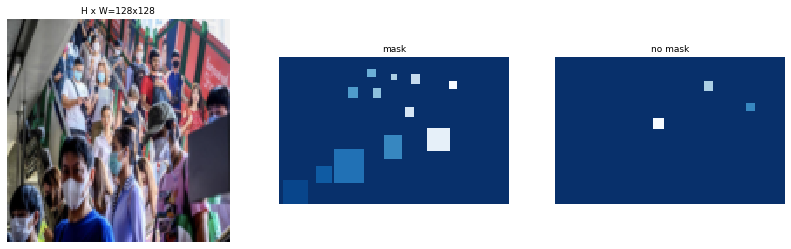

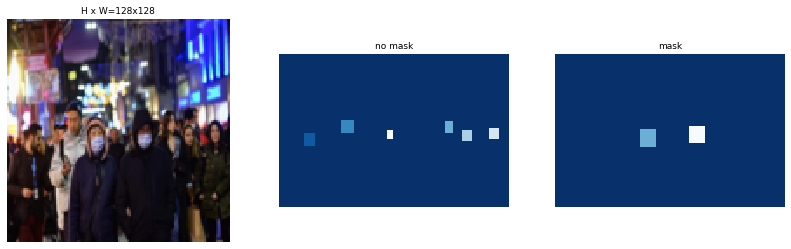

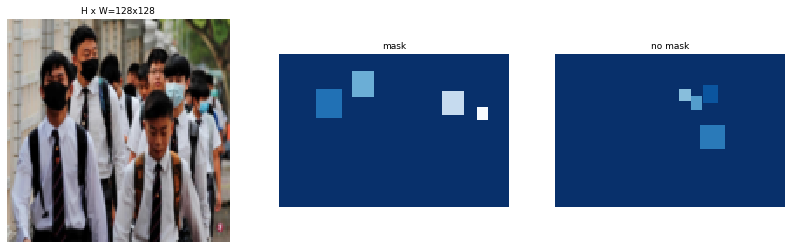

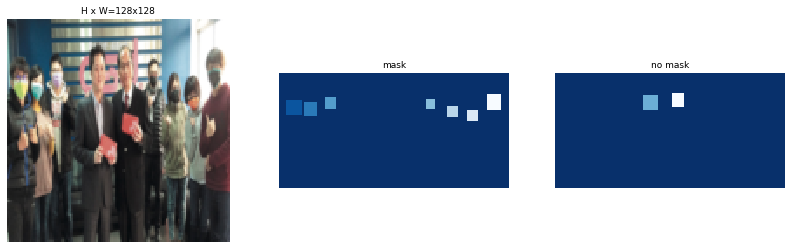

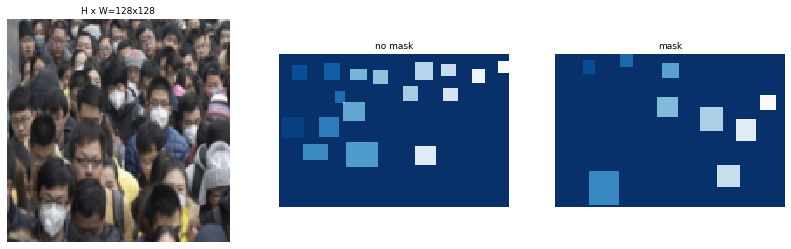

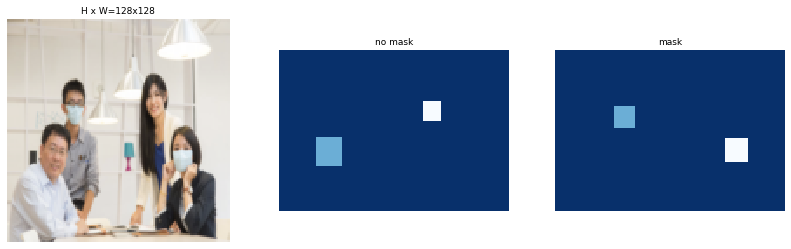

In [13]:
# Load and display a few samples
image_ids = [560, 571, 132, 165, 111, 97]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 2)

# Models and Evaluation

## Experimental Setup

We evaluated our methods by measuring accuracy, mean average precision (mAP), and generating a confusion matrix. Given that our task is a classification task and our model either predicts correctly or doesn't, these are reasonable evaluation metrics. The accuracy gives us a rough idea of how well our model predicts, the confusion matrix shows us what types of misclassifications our model makes, and mAP shows us what portion of our classifications are correct. 

#### Loss Function
We tried using accuracy and MSE (for bounding boxes) for our loss functions. 
Sticking to the Mask-RCNN architecture, we ended up using the Mask-RCNN's multi-task loss function, which combines the loss of classification, localization, and mask segmentation and can be written as $\mathcal{L} = \mathcal{L}_{cls} + \mathcal{L}_{box} + \mathcal{L}_{mask}$.  

$\mathcal{L}_{cls}$ is defined as $$\mathcal{L}_{cls} = -log p_u$$ where $p$ is the discrete probability distribution per RoI over k+1 classes, and u is the true class label.

$\mathcal{L}_{box}$ is defined as $$\mathcal{L}_{box} = \sum_{i \in x,y,w,h} L_1^{smooth}(t_i^u-v_i)$$ where $t^u = (t^u_x, t^u_y, t^u_w, t^u_h)$ is the predicted bounding box correction and $v = (v_x, v_y, v_w, v_h)$ is the true bounding box.  For "background" ROI this loss is ignored by the indicator function $\mathbb{1} [u \geq 1]$

$\mathcal{L}_{mask}$ is defined as average binary cross-entropy loss, and only includes the k-th mask if the region is associated with ground truth class k. That is
$$\mathcal{L}_{mask} = -\frac{1}{m^2}\sum_{1\leq i, j\leq m} [y_{ij} log \hat{y}_{ij}^k+ (1-y_{ij})log(1-\hat{y}_{ij}^k)]$$ where $y_{ij}$ is the label of a cell in the trus mask for the region of size m x m. 

However, in the future, we would like to test more loss functions or alter the Mask RCNN's loss function to optimize our model.  



#### Splitting Data
For our initial CNN, we did a train-test split using the sklearn split function to keep our data evenly distributed. We then trained on 75% of the data. However, in addition to this, we implemented data balancing by using the sklearn resample function and upsampled the minority class (improper mask wearing in our case) to match the number of samples with no mask. We also downsampled the majority class (proper mask) to match the number of no mask images in order to get a uniform distribution of our labels.

However, for the CNN we were passing in cropped photos of individual faces, but we switched to a Mask-RCNN based model wherein we passed in images with multiple faces to be identified, and thus had to change the way we split our data. For our final model based off Mask-RCNN, we assigned IDs to each image, randomized the IDs then did a 70-20-10 split(training, validation, test). 

Link to our **Github repository is [here](https://github.com/hittheant/475Project)**. In this repository, there are 3 different branches: `master`, `mrcnn`, and `yolo` which contain the different model impelmentations we tested out for this project.

## Baselines 

Initially, we intended to use a SVM as a baseline for mask adherence detection, but we found that it performed equivalent to our CNN on mask wearing detection. However, when we expanded our model to include face ROI detection, we found there was no equivalent comparison.

Overall, it was very difficult to find good baselines to compare against, as detecting face mask compliance is a relatively new problem. 

We used our BestNN network as a baseline for the cropped image classification task, and it provided us the results shown below.

    accuracy: 0.9087 val_accuracy: 0.8248

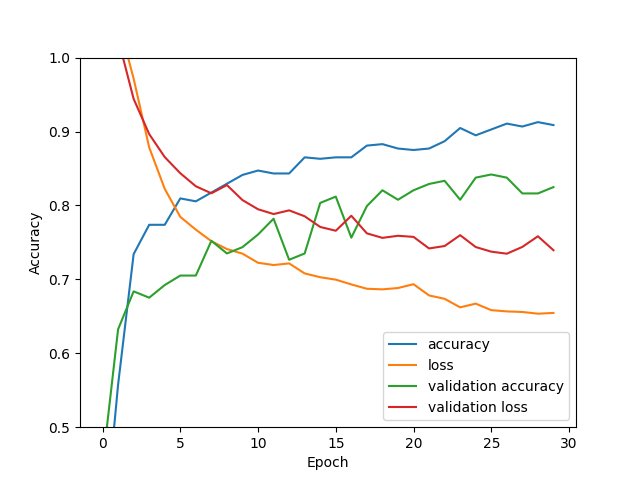

## Methods

We modified the Mask RCNN architecture (found [here](https://github.com/matterport/Mask_RCNN)) for the basis of our project. 

In our original CNN, we started out with a very complex model with several layers, yet found that this overfitting to our data. To accomodate this, we both decreased the learning rate and reduced the number of layers to improve our performance during validation. Ultimately, we found that a single layer was sufficient for our model. 

In order to expand our model to not requiring cropped images to be passed in, we worked to modify Mask-RCNN, which is a well known object detection model. Using Mask-RCNN allowed us to pass in uncropped images with multiple faces, generate bounding boxes around those faces, and classify mask adherence. 

In this updated model, we trained over 100 epochs with 5 validation epochs. We evaluated by looking at classification accuracy. To better visualize this, we created a confusion matrix to understand our model's performance. 

We found integrating masks with labels to be particularly difficult. Furthermore, training the model to do both was hard, as we have mostly worked on models with a singular goal in class.

The primary hyperparameter we tuned was the learning rate. The original learning rate for the MRCNN was 0.01, but we found that while this performed well on our training set, it underperformed on our test set. As a result, we decreased our learning rate to 0.001 for better performance on the test set.


Link to our Github repository is [here](https://github.com/hittheant/475Project). In this repository, there are 3 different branches: `master`, `mrcnn`, and `yolo` which contain the different model impelmentations we tested out for this project.


Simple Neural Network A was a CNN with three separate convolutional layers with structure as follows:

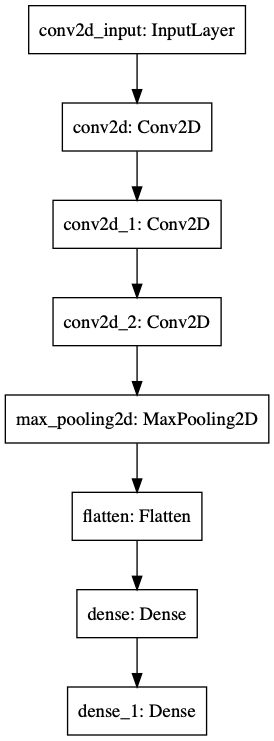

Simple Neural Network B was a CNN with a *single* convolutional layer, with structure as follows:

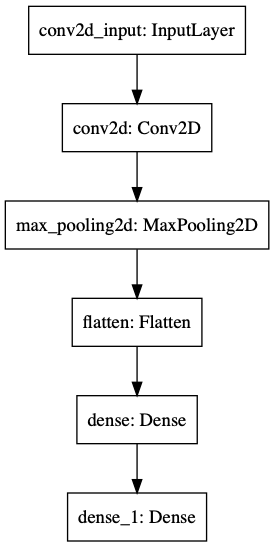

#### Simple Neural Networks A and B training length
Looking at the plot below, it looks like it could be beneficial to train this model more in order to improve training accuracy. However, we can see that training for too many epochs (>20) results in significant overfitting of our data because the validation accuracy starts to drop.

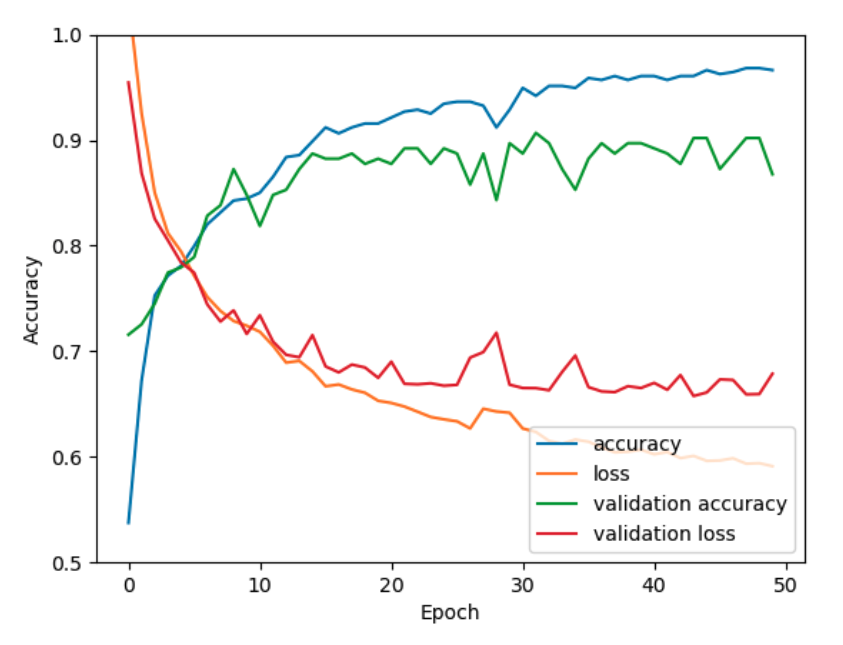

## Results

| Model | Baseline: BestNN| sNN-A   | sNN-B   |
|------|------|------|------|
| **Training Accuracy**  | 0.9087| 0.8846| 0.9118|
| **Validation Accuracy**| 0.8248| 0.8623| 0.8837|


These results surprised us because we had initially anticipated our BestNN to perform better than simple CNNs. However, after various model architectures, we identified that the simplest CNN (sNN-B above) performed the best on both our training and our testing set. This showed that sometimes, a simple model may perform better than a more complex model.

Initially, our models were overfitting. We could tell because, as shown in the cell above -- continuing to train would decrease training loss and increase training accuracy without impacting validation loss or accuracy much. This was also evident as our models would perform rather poorly on held out test sets despite having high training accuracies.

#### Confusion matrices for balanced vs unbalanced data
*Unbalanced data*

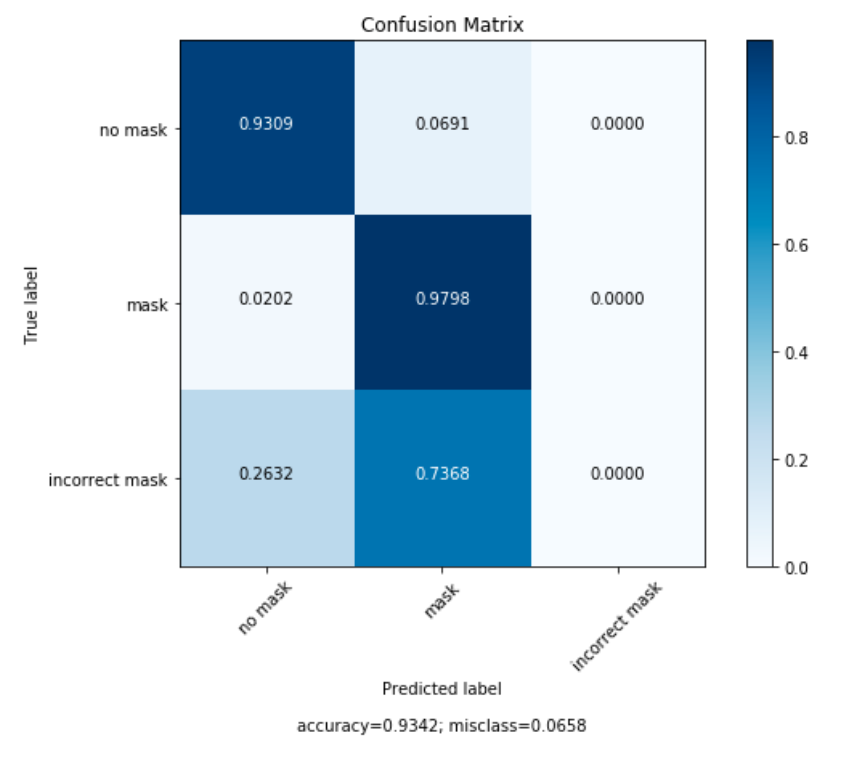

*Balanced data*

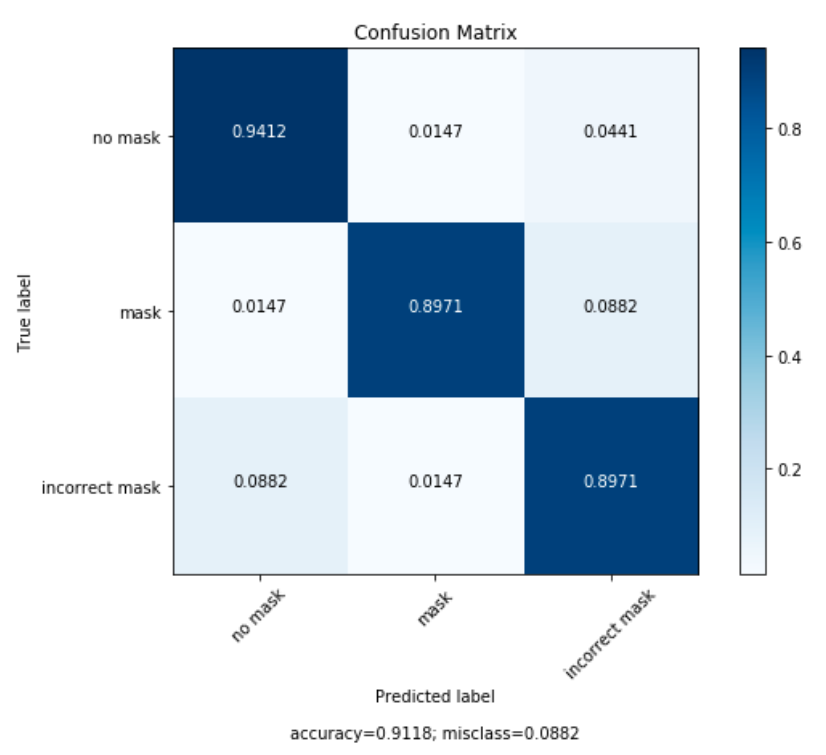

Overall, it was really interesting to see how our model behaved on balanced vs unbalanced data. If we were to transfer our model onto a different dataset, the balance of the different classes could likely affect the results as well.

In addition, we discovered that our data format with both bounding boxes and classes as labels was extremely difficult to work with. We spent a majority of our time trying to figure out our input and develop the `FacesDataset` class above.

#### Simple Neural Network A (three convolutional layers)

After simplifying down from the BestNN implementaiton, we attempted a CNN with 3 convolutional layers. As seen by the figure below, we can see that the validation accuracy seems to be lagging behind the training accuracy (even with a small learning rate of 0.0005. Still, while our training accuracies are worse than our baseline, we can see that our validation accuracy is higher by 0.05.

`accuracy: 0.8846 val_accuracy: 0.8623`

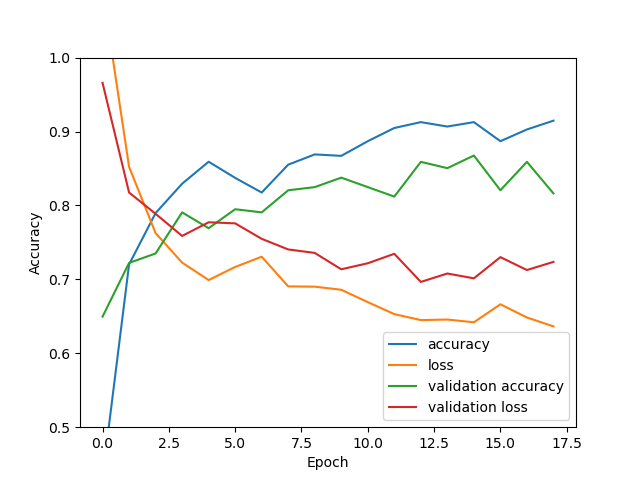

#### Simple Neural Network B (single convolutional layer)

For our best classification network, we identified that a single convolutional neural network performed the best. We can see that the accuracies are higher than what was achieved by our BestNN network.

`accuracy: 0.9118 val_accuracy: 0.8837`

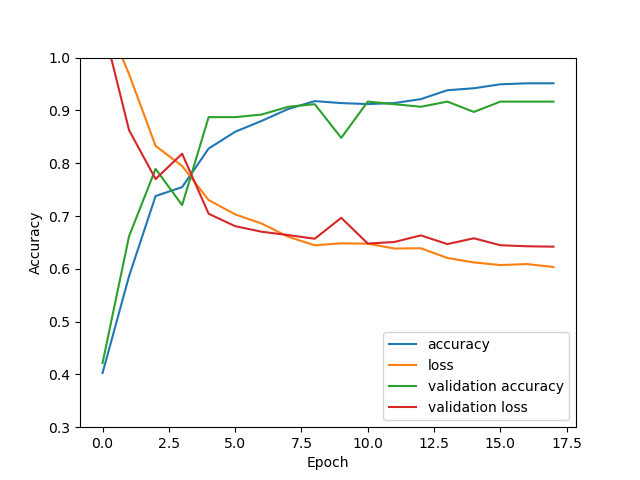

A lot of our more complex models are harder to visualize and evaluate because of the differences in datatypes. We weren't able to generate proper accuracy values because of misalignment between prediction and ground truth face identification labels. As the orders were different for each image, we were not able to match our values. However, based solely on visual inspection of random elements, it appears that our `MaskRCNN` network is able to identify faces and accurately classify them.

*Note: in the figures below, faces are randomly colored*

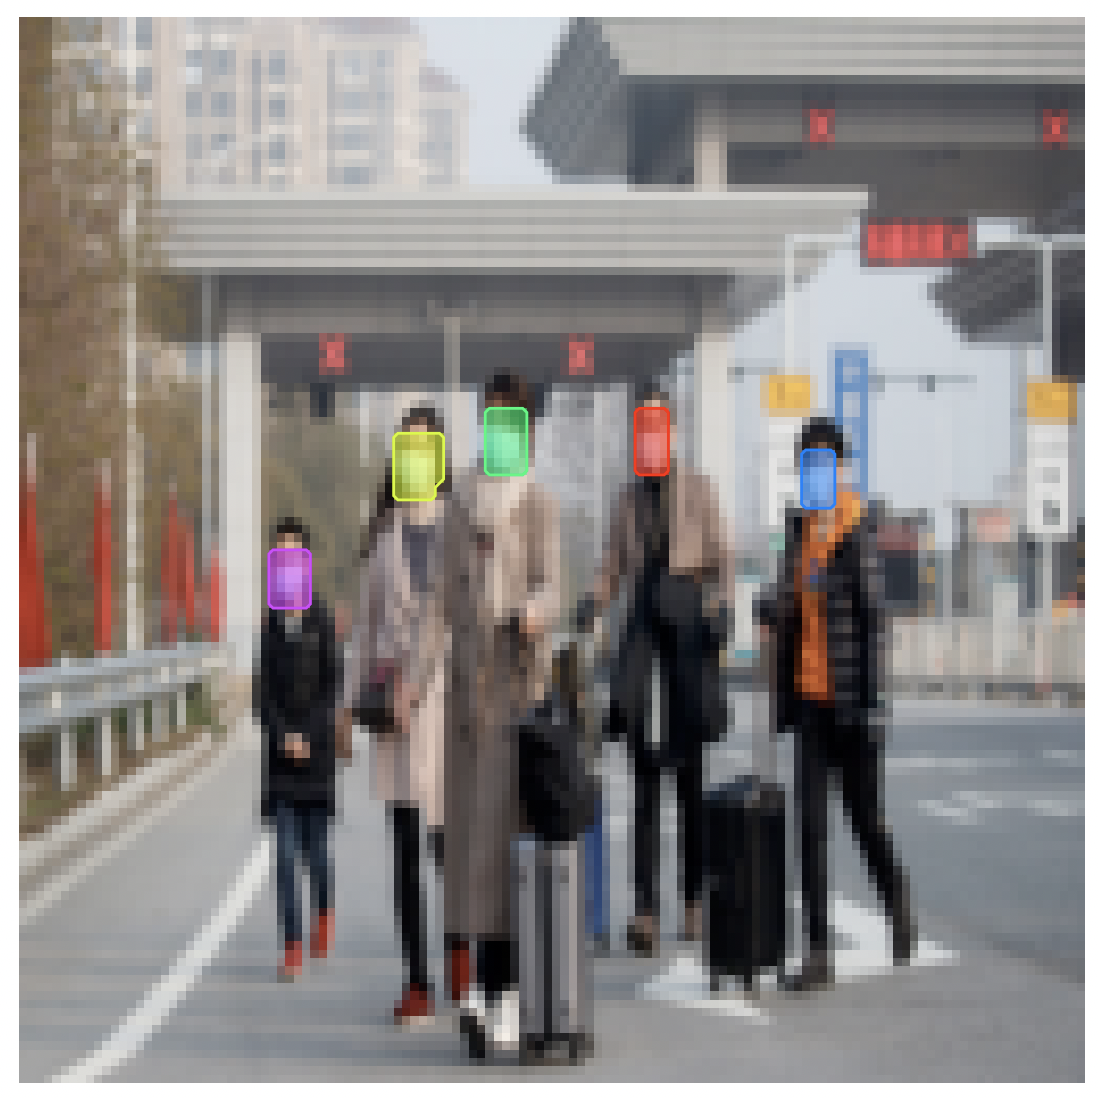

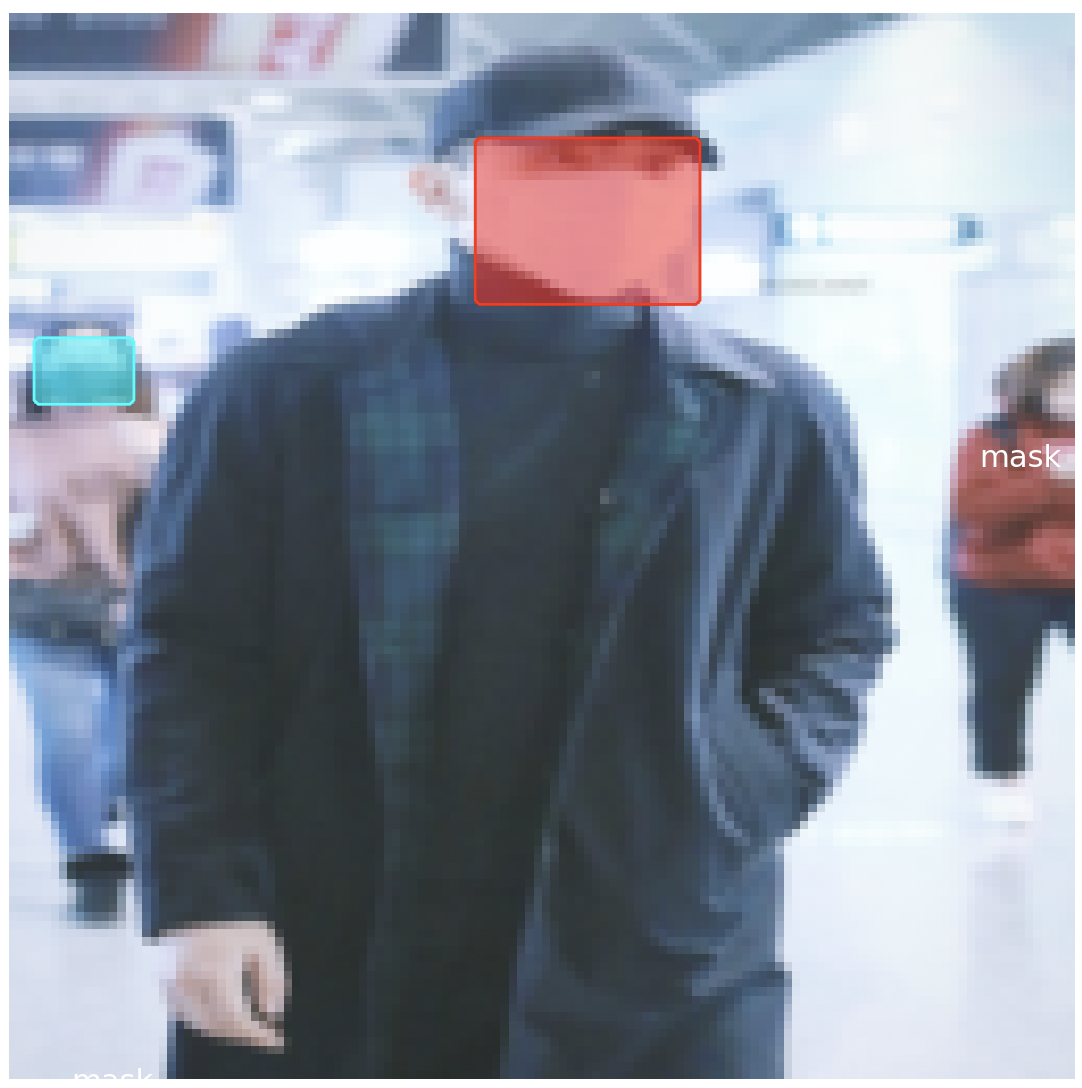

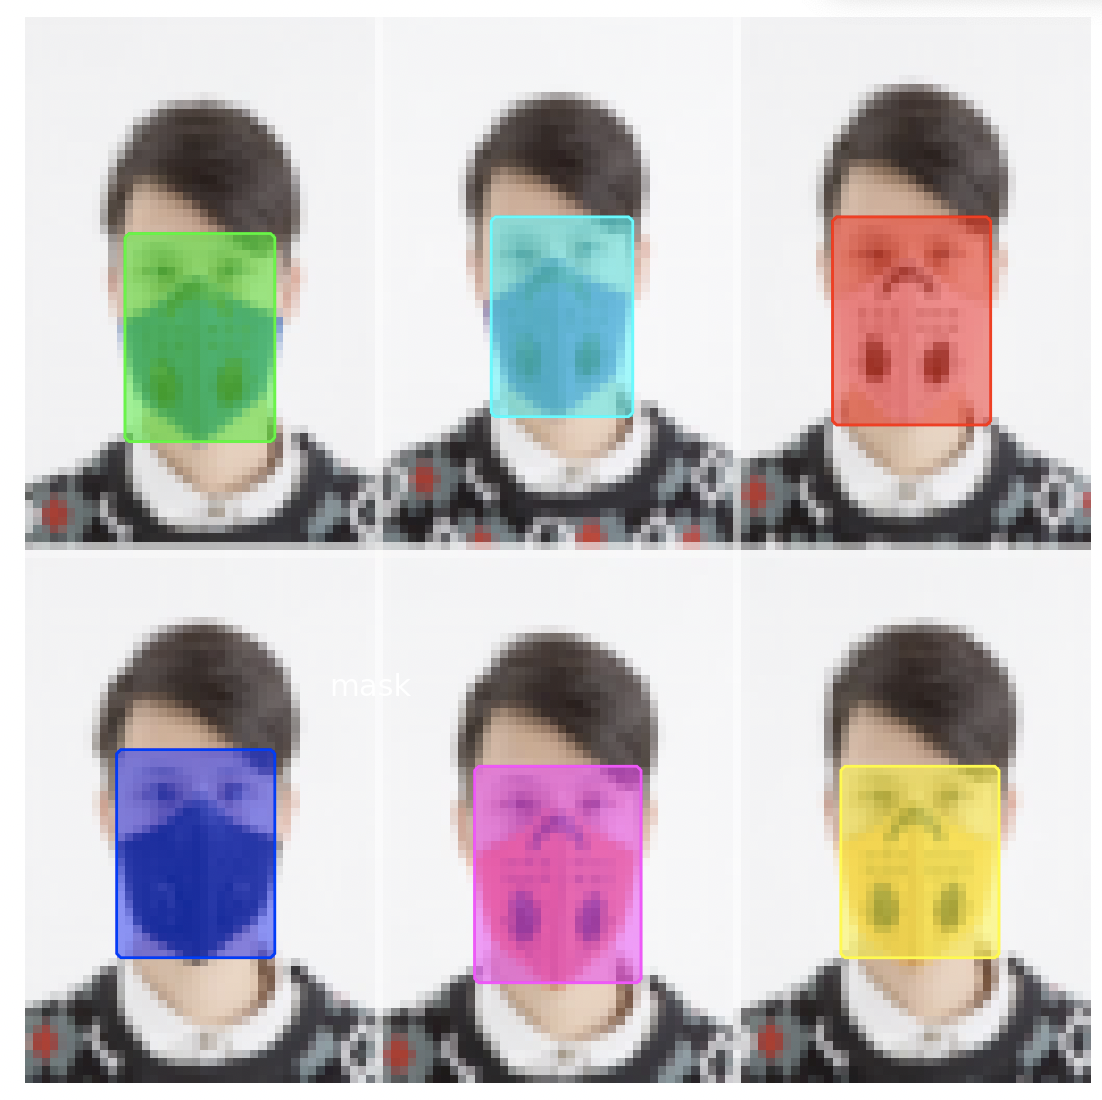


# Discussion

## What you've learned

#### **Coursework**

We found that the lessons on deep learning and neural networks were especially useful to us. These lectures gave us the foundation for building our project. Learning about current trends in machine learning also really helped us to identify key areas of machine learning that were of interest to us. Specifically, the various case studies on machine learning applications discussed in class were also extremely interesting and helped us understand the extent to which machine learning could be applied to solve real world problems. Learning about the different ethical implications of machine learning also helped to constrain some of the goals for this project to be realistic and respectful of privacy.


#### **Interesting parts of the project**

We found the lack of baseline options for our chosen problem very surprising. We thought that there would be more existing models that we could compare our performance against, but after comprehensive research, we found that there were none. We initially attempted to implement PCA and an SVM in order to establish a "baseline" for our model, but soon found it to be rather difficult as our problem had two separate components: region of interest identification and face classification.

We also learned that a simpler architecture can often times be better than a more complicated one. In our original mask-detection CNN, we found that our model with a single convolutional layer performed better than a more complex model with 3+ convolutional layers. In addition to this, the more complex models also took longer to train, making the simple convolutional neural network our best option. We also learned that using existing pretrained models (eg. MRCNN) can be extremely beneficial and time saving; however, fitting our data into the desired format can be time consuming and come with many problems of its own.

Overall, we found that training on a large, unbalanced dataset has a lot of varying pros and cons with new pitfalls for every change.

#### **Helpful feedback**

One group provided feedback suggesting that we penalize misclassification of "improper mask" more heavily in our objective function. We originally resolved this issue by balancing our classes in the training set of cropped faces. However, when we further expanded our model to identify faces and predict on faces, we found that it was not possible to "balance" classes like before. Potentially, implementing custom loss functions using things like the Sorensen-Dice coefficient and/or a combination of various losses could help us with this problem.

#### **Next steps (with more time)**

Given more time, we would like to apply LIME analysis to understand and interpret key features that our models are generating. Additionally, we would like to apply further data augmentation to modulate input quality, since if this model were used in the real world, it would need to handle poor or low quality images. We would also like to test a few more network architectures and modulate loss functions and different parameters more in order to find the best hyperparameter combination for our best model.

Finally, if we had more time, we would want to figure out a way to match our prediction labels with our ground truth labels (potentially using mean squared error). We would then use this to determine accuracy, precision, as well as confusion matrices as we did for our CNNs.


# References

K. He, G. Gkioxari, P. Dollar, and R. Girshick. “Mask R-CNN,” Jan. 2018. 

T. Chan, K. Jia, S. Gao, J. Lu, Z. Zeng and Y. Ma, "PCANet: A Simple Deep Learning Baseline for Image Classification?," in IEEE Transactions on Image Processing, vol. 24, no. 12, pp. 5017-5032, Dec. 2015, doi: 10.1109/TIP.2015.2475625.